In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


import pyro
#from svgsa.pathway_dispersion import select_highest_variance_gs
from sklearn.preprocessing import scale
#from svgsa.VAE import VAE
#from svgsa.Interface import fit_SVGSA
import torch
import pandas as pd
from tqdm import trange

import seaborn as sns
from matplotlib.pyplot import rc_context
import decoupler as dc
import svgsa


In [2]:
plt.style.use('ggplot')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [4]:
sc.settings.verbosity = 2

In [5]:
adata =  sc.datasets.pbmc68k_reduced()

In [6]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
#adata.obsm["raw"] = adata.raw.X.toarray().astype(np.float32)

In [8]:
# filter_genes = 100
# idx_to_filt = np.sum(adata.X > 0, axis = 0) > filter_genes
# adata = adata[:,idx_to_filt]
# #adata.obsm["raw"] = adata.obsm["raw"][:,idx_to_filt]

In [9]:
adata.X

array([[-0.326, -0.191, -0.728, ..., -0.21 , -0.636,  4.011],
       [ 1.171, -0.191,  0.795, ..., -0.21 ,  2.63 , -0.49 ],
       [-0.326, -0.191,  0.483, ..., -0.21 ,  0.663, -0.49 ],
       ...,
       [-0.326, -0.191, -0.728, ..., -0.21 , -0.636,  1.226],
       [-0.326, -0.191, -0.728, ..., -0.21 , -0.636, -0.49 ],
       [-0.326, -0.191,  0.148, ..., -0.21 , -0.636, -0.49 ]],
      dtype=float32)

In [10]:
### Loop the data lines
with open("data/cell_markers.txt", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

column_names = [i for i in range(0, max(col_count))]


gsts = pd.read_csv("data/cell_markers.txt",header=None, delimiter="\t", names=column_names,low_memory=False)

In [11]:
gsts

,0,1,2,3,4,5,6,7,8,9,...,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771
0,BUSSLINGER_ESOPHAGEAL_QUIESCENT_BASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,CXCL14,DST,COL17A1,KRT15,SLC7A5,COL7A1,IL1R2,ZFP36L2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BUSSLINGER_ESOPHAGEAL_PROLIFERATING_BASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,KRT14,DST,ASS1,TOP2A,COL17A1,KRT15,SLC7A5,MKI67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BUSSLINGER_ESOPHAGEAL_EARLY_SUPRABASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,MT2A,STMN1,CDK1,KRT5,H2AZ1,RRM2,HMGB2,TUBA1B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BUSSLINGER_ESOPHAGEAL_LATE_SUPRABASAL_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,SPRR3,CRNN,MAL,KRT4,SERPINB3,CSTB,SPRR1A,S100A9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BUSSLINGER_ESOPHAGEAL_DENDRITIC_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/B...,CD74,HLA-DRA,HLA-DRB1,HLA-DPA1,HLA-DQB2,HLA-DPB1,FCGBP,HLA-DQB1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,GAUTAM_EYE_IRIS_CILIARY_BODY_CILIARY_BODY_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,MLF2,RND3,CHRDL1,KIAA1671,DARS1,PEX16,STK17A,SLC7A8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,GAUTAM_EYE_CORNEA_CYTOTOXIC_T_CELLS,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,SUGP1,LDB1,CEP72,COQ8B,CDK19,SLC12A9,DELE1,CCDC144A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697,GAUTAM_EYE_IRIS_CILIARY_BODY_CRYAA_HIGH_CILIAR...,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,COX7A2L,RERE,KLF10,VTI1B,CSNK1E,JAM3,NLGN1,MAFF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,GAUTAM_EYE_IRIS_CILIARY_BODY_COL9A1_HIGH_CILIA...,http://www.gsea-msigdb.org/gsea/msigdb/cards/G...,SYNGR2,SPART,PABPC1L,TENM1,TRIO,RANBP1,ZIC3,TRMT11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
gsts = gsts.transpose()
gsts.columns = gsts.iloc[0]
gsts = gsts[2:]

In [13]:
gsts_dict = gsts.apply(lambda x: [x.dropna()]).to_dict("list")


In [14]:
gsts_dict["FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON"]

[2         ENC1
 3       PANTR1
 4    LINC01102
 5        MEIS2
 6          SLA
 7        CSRP2
 8        EIF1B
 Name: FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON, dtype: object]

In [15]:
# pip install git+https://github.com/saezlab/progeny-py

import progeny

n_genes = 500

model = progeny.load_model(
        organism='Human',
        top=n_genes # Number of top significant target genes per pathway to use
    )

model

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
A2M,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-4.132639,0.0,0.000000,0.0,0.000000,0.0,0.000000
A2M-AS1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-4.002327,0.0,0.000000,0.0,0.000000,0.0,0.000000
AADAC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.226882
AADAT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.101814,0.0,0.000000,0.0,0.000000,0.0,0.000000
AAMDC,0.0,0.0,0.0,0.0,0.0,-1.185075,0.000000,-2.815932,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.183463
ZSWIM3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2.566975,0.0,0.000000
ZSWIM8,0.0,0.0,0.0,0.0,0.0,-0.889425,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [16]:
gsts = model
#gsts.columns = gsts.iloc[0]
#gsts = gsts[2:]
gsts

pathway,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
gene,,,,,,,,,,,,,,
A2M,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-4.132639,0.0,0.000000,0.0,0.000000,0.0,0.000000
A2M-AS1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-4.002327,0.0,0.000000,0.0,0.000000,0.0,0.000000
AADAC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.226882
AADAT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.101814,0.0,0.000000,0.0,0.000000,0.0,0.000000
AAMDC,0.0,0.0,0.0,0.0,0.0,-1.185075,0.000000,-2.815932,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.183463
ZSWIM3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2.566975,0.0,0.000000
ZSWIM8,0.0,0.0,0.0,0.0,0.0,-0.889425,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [17]:
gsts_dict = gsts.apply(lambda x: gsts.index[np.abs(x) > 0.].tolist()).to_dict("list")
gsts_dict

{'Androgen': ['ABCA1',
  'ABCA12',
  'ABCC1',
  'ABCC4',
  'ABCG1',
  'ABCG2',
  'ABHD2',
  'ABI3BP',
  'ACACA',
  'ACAD8',
  'ACADL',
  'ACPP',
  'ACSL3',
  'ACSM1',
  'ADAM22',
  'ADAM7',
  'ADGRB2',
  'ADGRV1',
  'ADPGK',
  'ADPRM',
  'ADRA2A',
  'AFF3',
  'AFG3L2',
  'AKAP5',
  'ALDH1A3',
  'AMIGO2',
  'ANGPT2',
  'ANKH',
  'ANP32E',
  'APOF',
  'APPBP2',
  'ARHGAP1',
  'ARHGAP6',
  'ARHGEF26',
  'ATMIN',
  'ATP11B',
  'ATP1A1',
  'ATP2B1',
  'ATP6V1H',
  'ATP8A1',
  'ATXN2',
  'AZGP1',
  'BAMBI',
  'BARD1',
  'BAZ1B',
  'BBS4',
  'BBX',
  'BCAP29',
  'BCHE',
  'BMPR1A',
  'BMPR1B',
  'C16orf45',
  'C1orf115',
  'C1orf116',
  'C5orf30',
  'CAB39L',
  'CALU',
  'CAMK1D',
  'CAMKK2',
  'CAND1',
  'CAP2',
  'CARTPT',
  'CBLL1',
  'CCDC53',
  'CCDC93',
  'CCNK',
  'CD2AP',
  'CDC42BPA',
  'CDC42EP3',
  'CDK8',
  'CENPN',
  'CHKA',
  'CHPT1',
  'CHRNA2',
  'CLDN8',
  'CLGN',
  'CMC2',
  'CNGA1',
  'CNGB3',
  'CNKSR2',
  'CNTNAP2',
  'COBL',
  'COL5A2',
  'COLEC12',
  'COPB1',
  'COQ6',


In [18]:
pgy = dc.get_progeny(organism = "human", top = 500)
dc.run_wmean(mat=adata,net=pgy,source='source',target='target',weight='weight',verbose=True)
acts = dc.get_acts(adata, obsm_key='wmean_estimate')
sc.pp.scale(acts)

Running wmean on mat with 700 samples and 765 targets for 14 sources.


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


In [19]:
z_dim_gs = 8
z_dim_uns = 8

In [20]:
pyro.enable_validation()
#torch.autograd.set_detect_anomaly(True)

adata_new, model, loss, N_GS_list = svgsa.fit_SVGSA(adata, gsts_dict, z_dim_gs=z_dim_gs, z_dim_uns=z_dim_uns,
                                   
                                   num_iafs =0, batch_size=100, epochs=100, 
                                   
                                   N_GS=14, normalize = False,lr = 0.001, CUDA = True, iaf_dim=50, fixed = False)   #batch_size=1024

['Androgen' 'EGFR' 'Estrogen' 'Hypoxia' 'JAK-STAT' 'MAPK' 'NFkB' 'PI3K'
 'TGFb' 'TNFa' 'Trail' 'VEGF' 'WNT' 'p53']


Epoch loss 704631.030000: 100%|██████████| 100/100 [02:58<00:00,  1.78s/it]

score:  tensor([[ 1.3349, -0.6600,  0.4392,  ...,  0.4029, -1.3835, -0.5912],
        [ 0.6813, -0.0907, -1.5611,  ...,  0.2918, -0.2301,  0.4666],
        [ 0.5450,  1.9872,  0.1643,  ...,  1.6943, -0.0919,  0.7108],
        ...,
        [ 0.1659, -1.0040, -1.2758,  ...,  0.0960,  0.2195,  0.6740],
        [-0.7636,  0.5756,  0.6684,  ..., -0.6409,  0.3566,  0.6927],
        [-0.4370, -0.6659,  0.4283,  ..., -0.9823, -1.1093, -1.3306]],
       grad_fn=<SqueezeBackward0>)


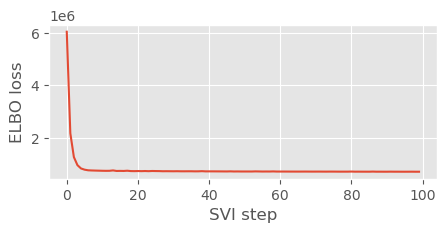

In [21]:
plt.figure(figsize=(5, 2))
plt.plot(loss)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [22]:
acts.obsm["X_svgsa"] = adata_new.obsm["X_svgsa"]
acts.obsm["X_svgsa_gs"] = adata_new.obsm["X_svgsa_gs"]
acts.obsm["X_svgsa_uns"] = adata_new.obsm["X_svgsa_uns"]
acts.obsm["last_node"] = adata_new.obsm["last_node"]

## Umap performed on the input data

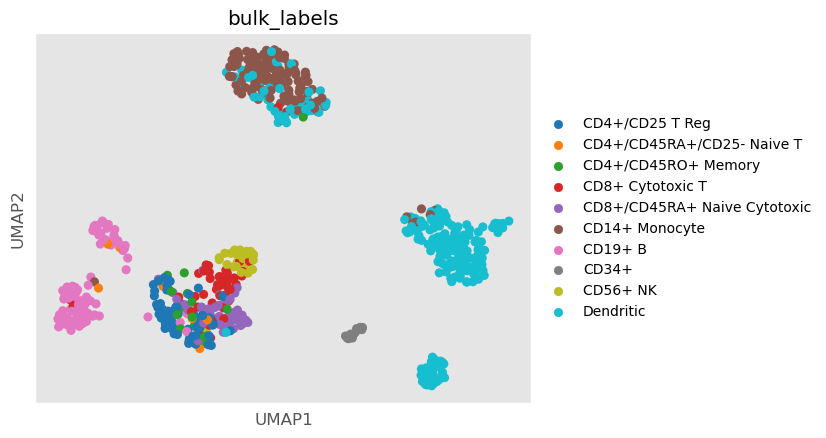

In [23]:
sc.pl.umap(adata, color = "bulk_labels")

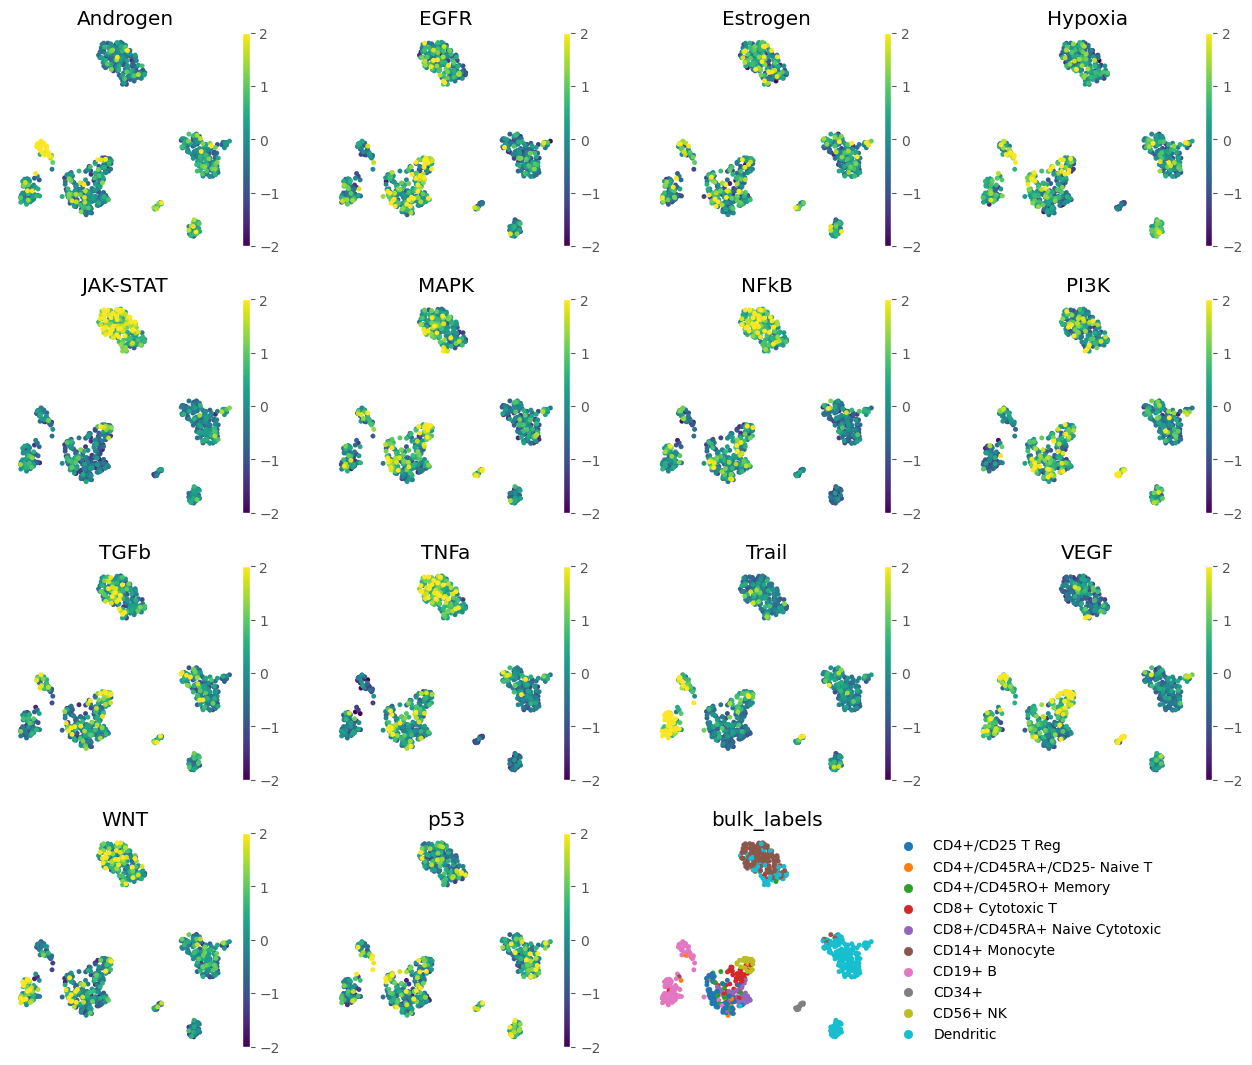

In [24]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata_new, color=list(N_GS_list) + ["bulk_labels"], s=50, frameon=False, ncols=4, vmin=-2, vmax=2)

## Comparison between last node gene set values and decoupler function run_wmean values

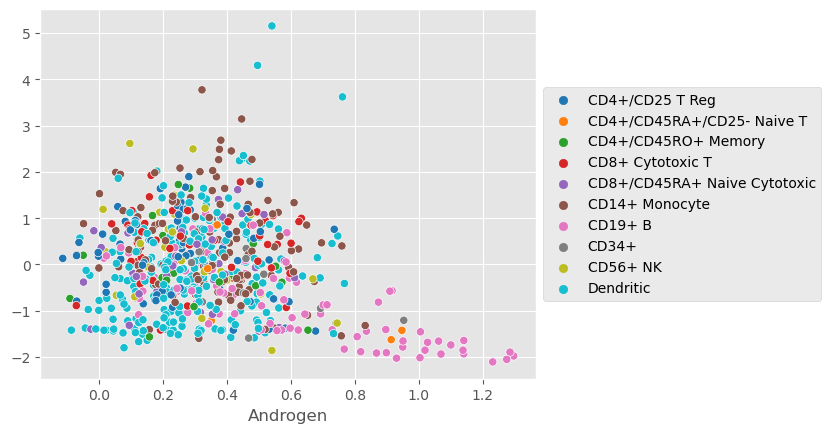

In [25]:
sns.scatterplot(x = adata_new.obsm["wmean_estimate"]["Androgen"], y = adata_new.obsm["last_node"][:,0], hue = adata_new.obs.bulk_labels, palette="tab10") 
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

## Only Gene Set Enocder latent space umap embedding

In [26]:
print( adata_new.obsm["X_svgsa_gs"].shape )
adata_new.obsm["X_svgsa_gs"]

(700, 8)


array([[-0.02682753, -1.8735987 , -1.6619014 , ...,  0.7657128 ,
        -1.2234267 , -0.81435674],
       [-0.36861503, -2.1931505 , -1.4950498 , ...,  2.8105984 ,
         0.11064816, -1.533926  ],
       [ 1.5763311 , -6.2983584 , -4.204602  , ...,  6.1360745 ,
        -1.1261638 , -6.14014   ],
       ...,
       [-0.07317999, -0.21095707, -0.8109133 , ...,  1.0682497 ,
         1.289932  ,  0.48114103],
       [-0.50325567,  2.3049457 ,  0.9502414 , ..., -1.704904  ,
         2.7947912 ,  2.256709  ],
       [ 0.2751371 ,  0.17375001,  0.15168066, ..., -1.863021  ,
        -2.1408498 ,  1.0571399 ]], dtype=float32)

computing neighbors
    finished (0:00:05)
computing UMAP
    finished (0:00:01)


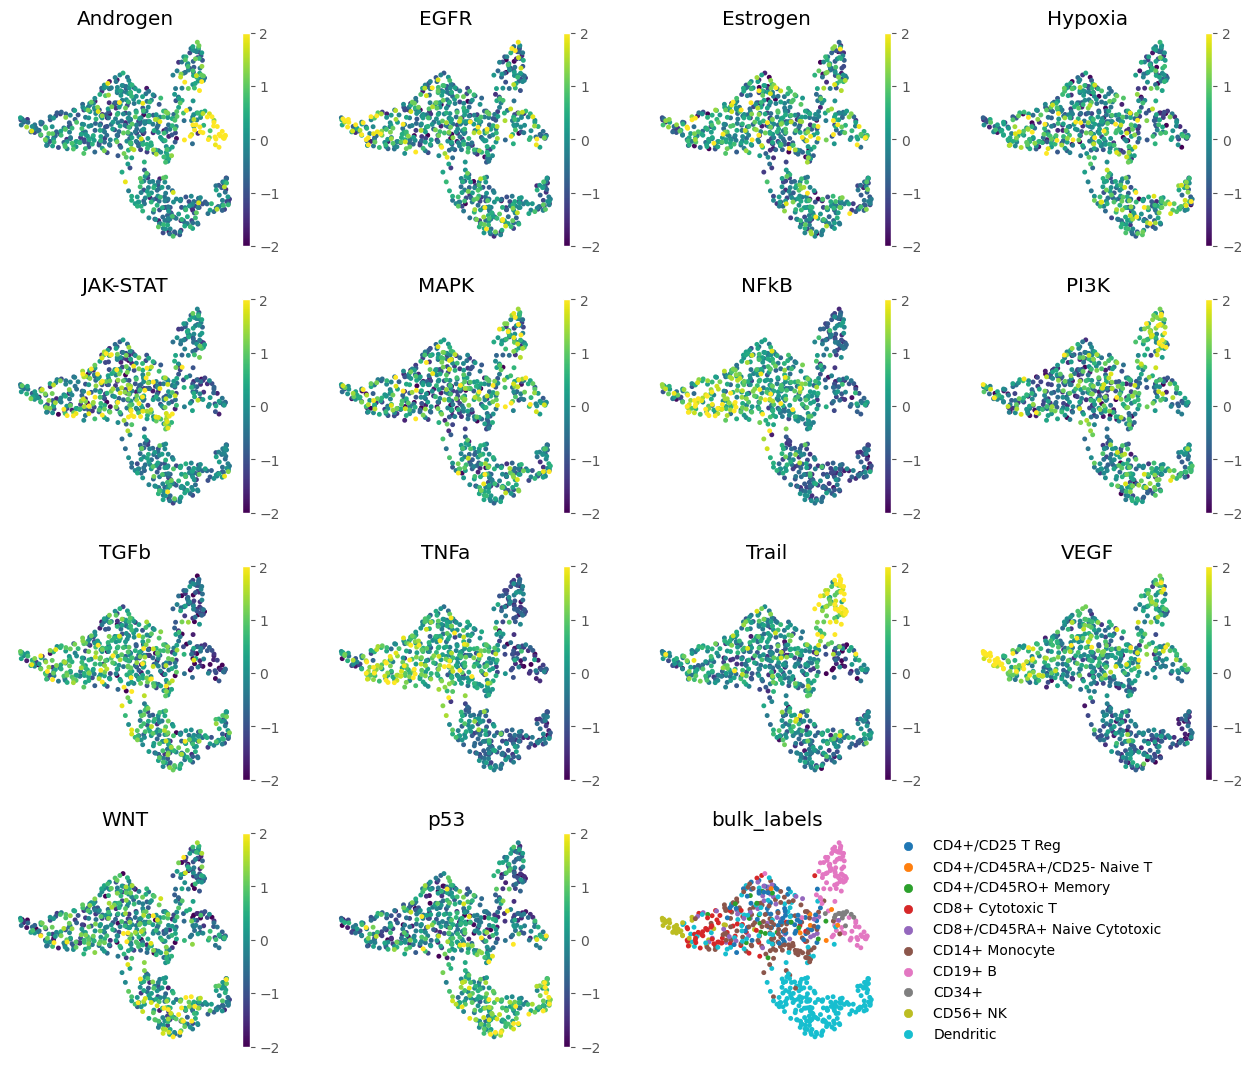

In [27]:
sc.pp.neighbors(acts, use_rep="X_svgsa_gs")
sc.tl.umap(acts, n_components=2)
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(acts, color=list(N_GS_list) + ["bulk_labels"], s=50, frameon=False, ncols=4, vmin=-2, vmax=2)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_bulk_labels']`


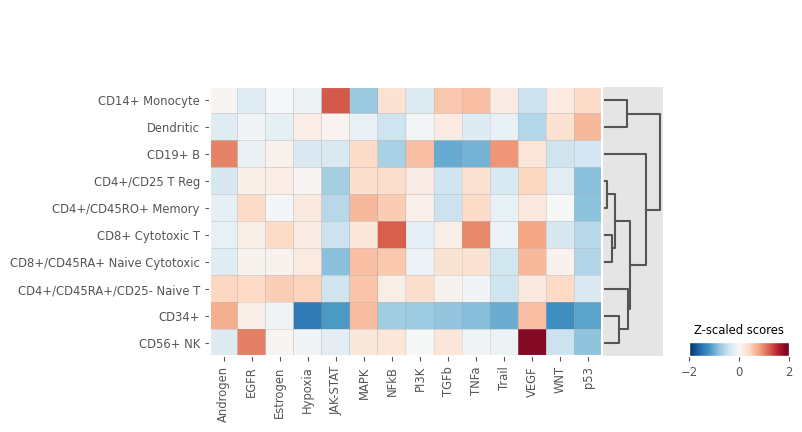

In [28]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='bulk_labels', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-2, vmax=2, cmap='RdBu_r')

## Only Unsupervised latent space umap embedding

In [29]:
print( adata_new.obsm["X_svgsa_uns"].shape )
adata_new.obsm["X_svgsa_uns"]

(700, 8)


array([[ 0.1437618 , 11.535077  , -5.707971  , ...,  1.9771259 ,
        -5.1377435 , -1.0729891 ],
       [-0.3159899 ,  8.549139  , -3.4711056 , ..., -1.6644257 ,
        -2.6344023 ,  2.0519874 ],
       [-7.8718843 ,  2.4431305 , -6.769747  , ..., -1.2124237 ,
        -0.13462351, -6.6902127 ],
       ...,
       [-0.6957415 ,  1.3693496 , -2.951209  , ...,  0.9462551 ,
        -0.6667689 , -7.6277795 ],
       [-8.687185  , -0.7863474 , -3.9121299 , ..., -3.3258111 ,
         1.3355805 , -5.6603856 ],
       [-2.9277523 ,  5.0260353 ,  2.0959756 , ...,  0.5306244 ,
        -3.971346  , -1.0338793 ]], dtype=float32)

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


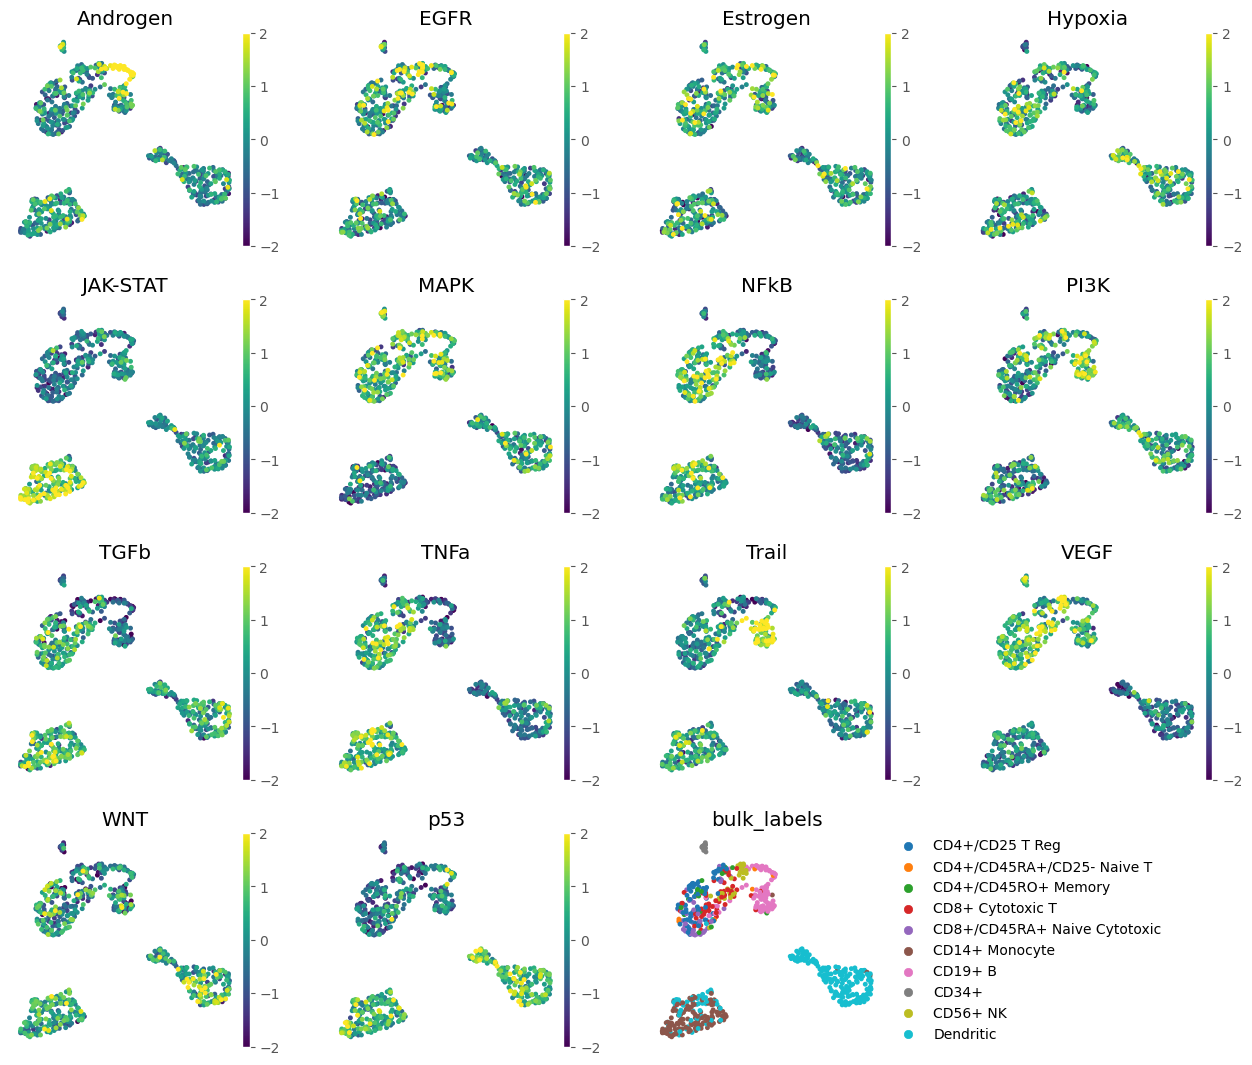

In [30]:
sc.pp.neighbors(acts, use_rep="X_svgsa_uns")
sc.tl.umap(acts, n_components=2)
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(acts, color=list(N_GS_list) + ["bulk_labels"], s=50, frameon=False, ncols=4, vmin=-2, vmax=2)

## Umap embedding of the two latent spaces combined

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


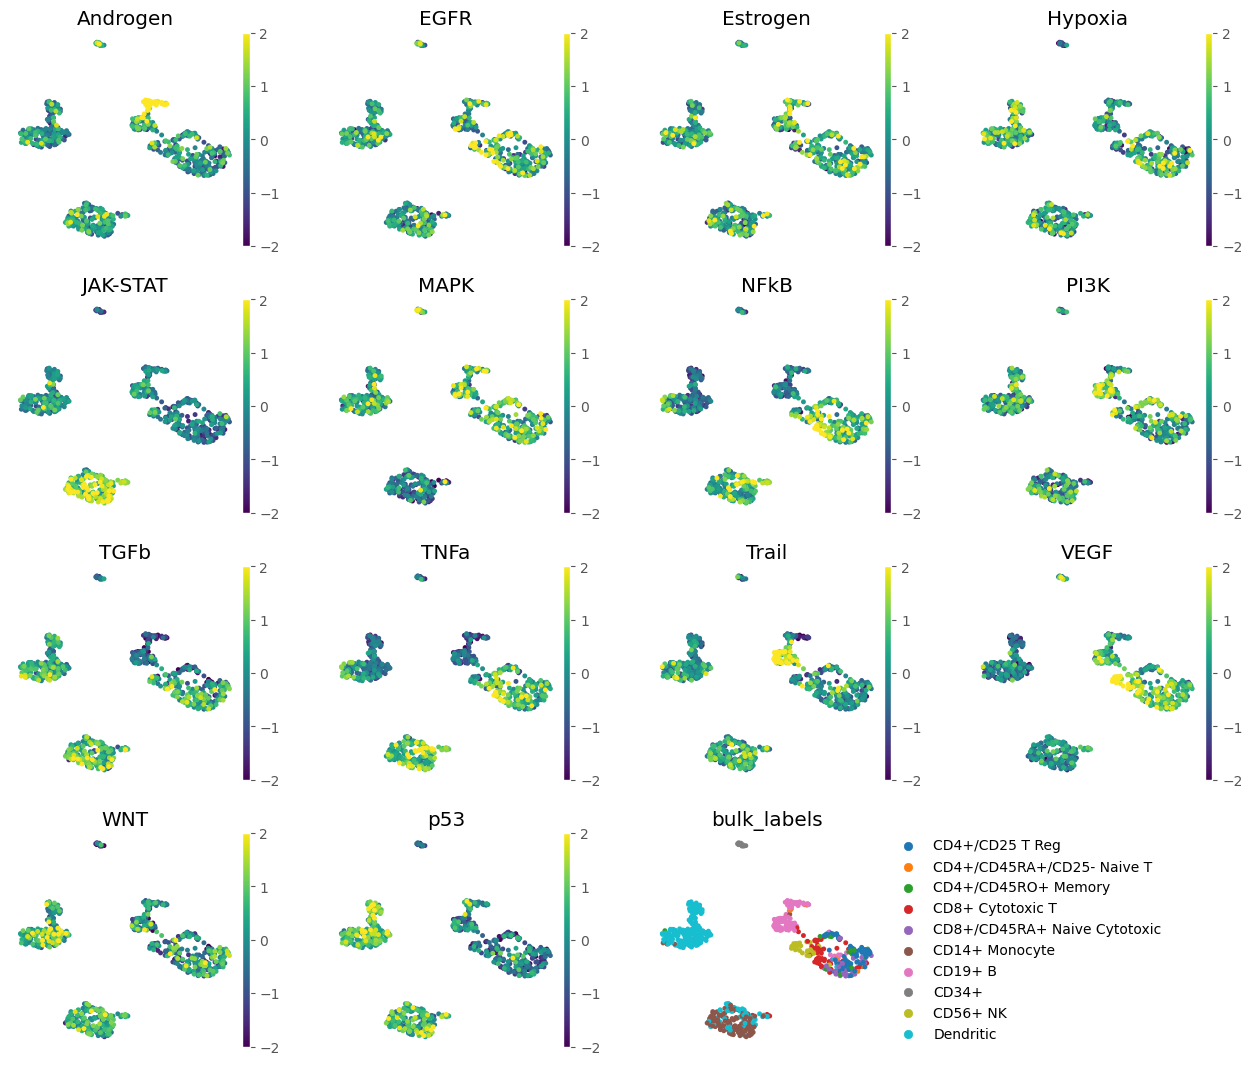

In [31]:
sc.pp.neighbors(acts, use_rep="X_svgsa")
sc.tl.umap(acts, n_components=2)
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(acts, color=list(N_GS_list) + ["bulk_labels"], s=50, frameon=False, ncols=4, vmin=-2, vmax=2)

In [32]:
print(adata_new.obsm["X_reconstructed"])

[[ 1.2008591  -0.13100892 -0.19536212 ...  0.03018516 -0.00943102
  -0.01507633]
 [ 1.3055835  -0.229374    0.05609444 ... -0.16565862 -0.03812402
  -0.05941382]
 [-0.02014083  0.05719747  0.37788308 ...  0.06490609  1.2743044
   0.03659533]
 ...
 [-0.29214597  0.15664217  0.15555209 ...  0.06812565  0.15502381
  -0.09330319]
 [-0.3800515  -0.2393621   0.00353399 ... -0.4115763  -0.24421532
  -0.20522535]
 [-0.4267415  -0.20490453 -0.1965845  ... -0.23711133  0.03265559
  -0.09817579]]


In [33]:
torch.tensor(adata.X)

tensor([[-0.3260, -0.1910, -0.7280,  ..., -0.2100, -0.6360,  4.0110],
        [ 1.1710, -0.1910,  0.7950,  ..., -0.2100,  2.6300, -0.4900],
        [-0.3260, -0.1910,  0.4830,  ..., -0.2100,  0.6630, -0.4900],
        ...,
        [-0.3260, -0.1910, -0.7280,  ..., -0.2100, -0.6360,  1.2260],
        [-0.3260, -0.1910, -0.7280,  ..., -0.2100, -0.6360, -0.4900],
        [-0.3260, -0.1910,  0.1480,  ..., -0.2100, -0.6360, -0.4900]])

# Standard analysis

In [34]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 404 cells that have less than 200 genes expressed
filtered out 6 genes that are detected in less than 3 cells


In [35]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [36]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [37]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)


c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [38]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:03)


In [39]:
sc.pp.scale(adata, max_value=10)


In [40]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [41]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00)


In [42]:
sc.tl.umap(adata)


computing UMAP
    finished (0:00:01)


In [43]:
sc.tl.leiden(adata)


running Leiden clustering
    finished (0:00:00)


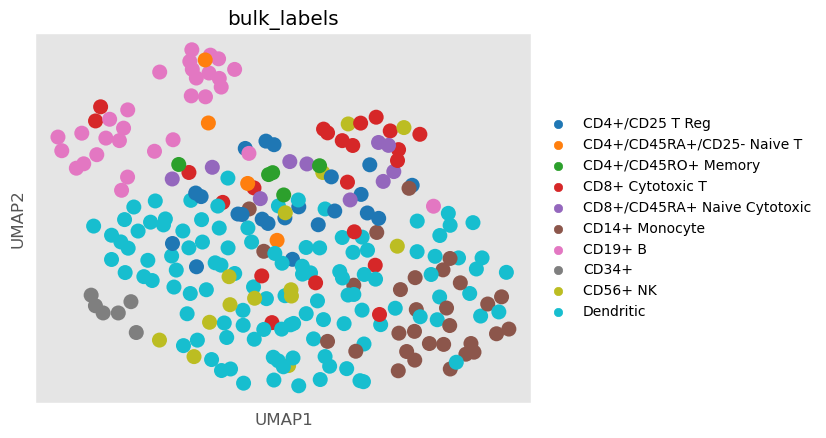

In [44]:
sc.pl.umap(adata,  color = "bulk_labels")